In [2]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

In [3]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE, '\ttorch : ', torch.__version__)

cuda 	torch :  1.12.0


In [4]:
BATCH_SIZE = 128 
EPOCHS = 100

In [5]:
train_dataset = datasets.MNIST(root = '../../data/MNIST',
                               train=True,
                               download=True,
                               transform= transforms.ToTensor())
train_loader= torch.utils.data.DataLoader(train_dataset,
                                          shuffle = True,
                                          batch_size = BATCH_SIZE)

test_dataset = datasets.MNIST(root = '../../data/MNIST',
                               train=False,
                               download=True,
                               transform= transforms.ToTensor())
test_loader= torch.utils.data.DataLoader(train_dataset,
                                          shuffle = False,
                                          batch_size = BATCH_SIZE)

In [6]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


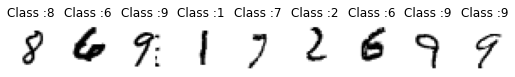

In [7]:
pltsize = 1 
plt.figure(figsize=(pltsize * 10, pltsize))

for i in range(1, 10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap= 'gray_r')
    plt.title('Class :' + str(y_train[i].item()))
plt.show()

In [9]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.dropout_prob = 0.5

    def forward(self, x) :
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [10]:
import torch.nn.init as init 
def weight_init(m) :
    # m이 리니어모델인지 확인
    if isinstance(m, nn.Linear) :
        init.kaiming_uniform(m.weight.data)

In [25]:
del model

In [26]:
model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


C:\Users\Admin\AppData\Local\Temp\ipykernel_23900\4249598189.py:4: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)


In [27]:
def train(model, train_loader, optimizer, log_intervals = 100) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_Loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [28]:
def evaluate(model, test_loader) :
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss = test_loss / len(test_loader)
        test_accuracy = correct * 100 / len(test_loader.dataset)
    return test_loss, test_accuracy

In [29]:
best_acc = 0 
es = 0 
for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEPOCH : {}, Test_Loss : {:.4f} \t Test_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_acc  :
        best_acc = test_accuracy
        best_model = model
        es = 0
    else :
        es += 1

    if es >= 10 :
        print('Best_accuracy : {:.2f}'.format(
            best_acc
        ) )
        break

Train_Epoch : 1, [0 / 60000](0%)	Train_Loss : 2.972326
Train_Epoch : 1, [12800 / 60000](21%)	Train_Loss : 0.284011
Train_Epoch : 1, [25600 / 60000](43%)	Train_Loss : 0.258938
Train_Epoch : 1, [38400 / 60000](64%)	Train_Loss : 0.196030
Train_Epoch : 1, [51200 / 60000](85%)	Train_Loss : 0.235824

EPOCH : 1, Test_Loss : 0.0004 	 Test_accuracy : 96.71%

Train_Epoch : 2, [0 / 60000](0%)	Train_Loss : 0.322983
Train_Epoch : 2, [12800 / 60000](21%)	Train_Loss : 0.237356
Train_Epoch : 2, [25600 / 60000](43%)	Train_Loss : 0.239584
Train_Epoch : 2, [38400 / 60000](64%)	Train_Loss : 0.220612
Train_Epoch : 2, [51200 / 60000](85%)	Train_Loss : 0.155163

EPOCH : 2, Test_Loss : 0.0004 	 Test_accuracy : 97.60%

Train_Epoch : 3, [0 / 60000](0%)	Train_Loss : 0.149787
Train_Epoch : 3, [12800 / 60000](21%)	Train_Loss : 0.338178
Train_Epoch : 3, [25600 / 60000](43%)	Train_Loss : 0.076608
Train_Epoch : 3, [38400 / 60000](64%)	Train_Loss : 0.287628
Train_Epoch : 3, [51200 / 60000](85%)	Train_Loss : 0.145933

